In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as st

ImportError: DLL load failed: La procédure spécifiée est introuvable.

In [2]:
def answeredTrue(answer):
    if answer.get('0') is not None:
        return 1
    else:
        return 0

def valueOrZero(answer):
    if answer.get('value'):
        if int(answer['value']) < 0 or int(answer['value']) > 10:
            raise Exception('This mf right there')
        return int(answer['value'])
    else:
        return 0
    
def loadData(path):
    with open(path) as f:
        jfile = json.load(f)
    return jfile['payload']

def sortScores(scores):
    return sorted(list(scores.items()), key=lambda s: -s[1])

In [3]:
path_guess_the_trick = 'ac/1-guess-the-trick__p1__ac-quiz-2hul/product.json'
path_user_mapping = 'op/argue-with-constrai__op-argue-constraint-3fzq/object.json'
path_peer_review = 'ac/5-review-your-partners__p1__ac-quiz-2jjm/product.json'
path_auto_review = 'ac/6-auto-review__p1__ac-quiz-1jpz/product.json'
path_ranking_t1 = 'ac/6-ranking-t1__p1__ac-ranking-8blf/product.json'
path_ranking_t2 = 'ac/6-ranking-t2__p1__ac-ranking-b07c/product.json'
path_review_pairing = 'op/argue-with-constrai__op-argue-constraint-3fzq/product.json'
path_groups = 'op/create-groups__op-create-groups-8lh1/product.json'

## Preparation: user mapping

In [4]:
with open(path_user_mapping) as f:
    mapping = json.load(f)
idToStud = mapping['globalStructure']['students']
studToId = {v: k for k, v in idToStud.items()} #inverse mapping

In [5]:
with open(path_groups) as f:
    trick_groups = json.load(f)['socialStructure']['group']

#odd: trick 1 (packet flip trick), pair: trick 2 (bent card trick)
def groupNumber(student):
    for groupNumber, groupList in trick_groups.items():
        if student in groupList:
            return int(groupNumber)
    return -1

## First part: evaluate magic knowledge

In [6]:
data = loadData(path_guess_the_trick)

In [7]:
knowledge = {}
saw_changed_cap = []
for student in data:
    d = {}
    answers = data[student]['data']['form']
    d['guess_trick'] = answers['0']['text']
    score = 0
    score += answeredTrue(answers['1'])
    for mcq in answers['2']:
        if mcq and mcq not in ['0', 'text']: #For each kind of magic trick learned
            score+=1
    score += valueOrZero(answers['3']) #Magic knowledge
    if answeredTrue(answers['4']) == 1:
        saw_changed_cap.append(student)
    d['score'] = score
    knowledge[student] = d

In [8]:
#Parse answers
#You'll be prompted the text the student wrote and you can grade his/her answers
for student in knowledge:
    mark = int(input(knowledge[student]['guess_trick']))
    previous_score = knowledge[student]['score']
    knowledge[student].pop('guess_trick')
    knowledge[student].pop('score')
    knowledge[student] = previous_score + mark

At the second time, the coin falls on your knees1
I think he dropped the piece off the table before scratching his arm1
0
I don't know.0
I'm not sure (was still logging into frog, sorry!)0
Two coins stacked on top of each other, then sweeps then onto lap;
Could also be one coin but got hinted/misdirected at two with the doublelift video 0
he hides the coin with the arm and hand which he used to hold the coin when he lets it drop.1
0
the coin fall on the knees of the magician1
No idea0
I missed the trick :( 0
coin falls down1
The coin fell out of the screen video almost, so the magician simply pushed the coin out of the screen, instead of reaching out to pick it up.0
third time you throw the coin under the table.1
0
0
The coin fell in his lap 1
0
Distraction by letting the coin going away, the second time you glide it under the table (?)1
The first 2 times, the coin falls on the table. That makes us watch the falling point on the thrid time, misleading us no to see the coin fall on the 

In [9]:
knowledge_ranked = sortScores(knowledge)
print(knowledge_ranked)

[('3C2G6L2Lb7Xc9pWLE', 16), ('SeuW5C9Zh7BYK6qCb', 13), ('tGZEmTZtkhSJMp2u6', 9), ('WxQyEYgu2aYuFhvBB', 8), ('QiKRKRbxb8kMjYiLH', 7), ('aq7paoDD2G6YADc2Y', 7), ('5evKgJk6KjDdDqSZZ', 6), ('EBTm8RrapfNuTADYE', 6), ('g939ZKLYnmXXcYYmd', 6), ('p6jyEN63CBePh9pJL', 6), ('si96GLusTjpboyLXY', 6), ('F8QHpjcxav78R9o62', 5), ('KngyjFCgLrzfN6XaR', 5), ('cJ9ydcLaGxLuvMgEw', 5), ('YLSgM2PrWYhGfjhoz', 4), ('tkMkquazFa4TZBd8C', 1), ('9CBRzuDF4CNFmrAQq', 0), ('RpdvawqmcQcXKLAcL', 0), ('jejaoCvoJPnvTFC3X', 0), ('miDuMw8zNEk2aC6FM', 0), ('sY2PHLSsXkPtG4hWy', 0)]


## Second part: partner evaluation

In [10]:
data = loadData(path_peer_review)
with open(path_review_pairing) as f:
    pairing = json.load(f)['socialStructure']['group']

def findPartner(studID):
    for _, pairList in pairing.items():
        if studID in pairList:
            index = pairList.index(studID)
            size = len(pairList)
            return pairList[(size-1 + index) % size] #return the next element in list

In [11]:
mcq_answer_t1 = {"0": False, "1": True, "2": False, "3": False, "text": ""} #Only misdirection
mcq_answer_t2 = {"0": True, "1": False, "2": False, "3": False, "text": ""} #Only double lift

In [12]:
review_scores = {}
for student in data:
    paired_student = findPartner(student)
    answers = data[student]['data']['form']
    if not answers['3']['text']:
        review_scores[paired_student] = -1
        continue
    else: #check answers manually
        self_score = input(answers['3']['text']) #Leave empty to invalidate
        if not self_score:
            review_scores[paired_student] = -1
            continue
        self_score = int(self_score)
        partner_score = answeredTrue(answers['0']) * 5 #Fooled
        partner_score += valueOrZero(answers['1']) #Performance
        if groupNumber(student) % 2 == 0: #Techniques used
            #trick 2
            self_score += int(answers['2'] == mcq_answer_t2)
        else:
            #trick 1
            self_score += int(answers['2'] == mcq_answer_t1)
            
        if review_scores.get(paired_student):
            review_scores[paired_student] += partner_score
        else:
            review_scores[paired_student] = partner_score
        
        if review_scores.get(student):
            review_scores[student] += self_score
        else:
            review_scores[student] = self_score

She misdirected me but we weren't able to record it for dropbox reasons unfortunally1
I'm sorry but the video on frog did not work for me, so I was unable to join a teammate and show my trick or see my teammate's trick. Sorry for the inconveniance....
I was alone in the reunion
It was too fast (we took the whole time to set up recording on Dropbox) so it was hard for me to understand what he was saying, he did it so fast!
I already knew the trick; The deck was prepped by flipping it and putting one card face down before putting the pulled card into the deck. I did get misdirected though but knew how the trick worked so i could figure it out afterhand1
I couldn't join a room to show the trick. So I won't answer the above to not bias anything.
He didn't have time to perform
He dissimulated the right card with the double lift or something1
My camera and mic did not work somehow on frog I could not do the activity sorry :( 
We couldn't complete the trick, my classmate's microphone wasn't w

In [13]:
review_scores_ranked = sortScores(review_scores)
review_scores_ranked

[('KngyjFCgLrzfN6XaR', 15),
 ('cJ9ydcLaGxLuvMgEw', 12),
 ('WxQyEYgu2aYuFhvBB', 9),
 ('3C2G6L2Lb7Xc9pWLE', -1),
 ('RpdvawqmcQcXKLAcL', -1),
 ('p6jyEN63CBePh9pJL', -1),
 ('YLSgM2PrWYhGfjhoz', -1),
 ('SeuW5C9Zh7BYK6qCb', -1),
 ('tGZEmTZtkhSJMp2u6', -1),
 ('5evKgJk6KjDdDqSZZ', -1),
 ('F8QHpjcxav78R9o62', -1),
 ('EBTm8RrapfNuTADYE', -1),
 ('si96GLusTjpboyLXY', -1),
 ('sY2PHLSsXkPtG4hWy', -1),
 ('tkMkquazFa4TZBd8C', -1),
 ('g939ZKLYnmXXcYYmd', -1),
 ('9CBRzuDF4CNFmrAQq', -1),
 ('miDuMw8zNEk2aC6FM', -1),
 ('aq7paoDD2G6YADc2Y', -1),
 ('QiKRKRbxb8kMjYiLH', -1),
 ('jejaoCvoJPnvTFC3X', -1)]

## Third part: auto evaluation

In [14]:
data = loadData(path_auto_review)

In [15]:
auto_eval = {}
for student in data:
    answers = data[student]['data']['form']
    score = 0
    score += valueOrZero(answers['0']) #Rate performance
    score += valueOrZero(answers['1']) #How well will you remember
    score += answeredTrue(answers['2']) #Better with more time
    try:
        risky_answer = valueOrZero(answers['3']) #Fool colleague
    except:
        print(idToStud[student], ' rated an invalid score of ', int(answers['3']['value']))
    #score += valueOrZero(answers['3']) #Fool colleague
    score += risky_answer
    auto_eval[student] = score
auto_eval

Yannis David Charpilloz  rated an invalid score of  -1
pol  rated an invalid score of  -1


{'3C2G6L2Lb7Xc9pWLE': 29,
 '5evKgJk6KjDdDqSZZ': 13,
 '9CBRzuDF4CNFmrAQq': 18,
 'EBTm8RrapfNuTADYE': 15,
 'F8QHpjcxav78R9o62': 10,
 'KngyjFCgLrzfN6XaR': 11,
 'QiKRKRbxb8kMjYiLH': 12,
 'RpdvawqmcQcXKLAcL': 0,
 'SeuW5C9Zh7BYK6qCb': 16,
 'WxQyEYgu2aYuFhvBB': 27,
 'YLSgM2PrWYhGfjhoz': 1,
 'aq7paoDD2G6YADc2Y': 0,
 'cJ9ydcLaGxLuvMgEw': 8,
 'g939ZKLYnmXXcYYmd': 29,
 'jejaoCvoJPnvTFC3X': 0,
 'miDuMw8zNEk2aC6FM': 0,
 'p6jyEN63CBePh9pJL': 0,
 'sY2PHLSsXkPtG4hWy': 0,
 'si96GLusTjpboyLXY': 22,
 'tGZEmTZtkhSJMp2u6': 22,
 'tkMkquazFa4TZBd8C': 18}

In [16]:
auto_eval_ranked = sortScores(auto_eval)
auto_eval_ranked

[('3C2G6L2Lb7Xc9pWLE', 29),
 ('g939ZKLYnmXXcYYmd', 29),
 ('WxQyEYgu2aYuFhvBB', 27),
 ('si96GLusTjpboyLXY', 22),
 ('tGZEmTZtkhSJMp2u6', 22),
 ('9CBRzuDF4CNFmrAQq', 18),
 ('tkMkquazFa4TZBd8C', 18),
 ('SeuW5C9Zh7BYK6qCb', 16),
 ('EBTm8RrapfNuTADYE', 15),
 ('5evKgJk6KjDdDqSZZ', 13),
 ('QiKRKRbxb8kMjYiLH', 12),
 ('KngyjFCgLrzfN6XaR', 11),
 ('F8QHpjcxav78R9o62', 10),
 ('cJ9ydcLaGxLuvMgEw', 8),
 ('YLSgM2PrWYhGfjhoz', 1),
 ('RpdvawqmcQcXKLAcL', 0),
 ('aq7paoDD2G6YADc2Y', 0),
 ('jejaoCvoJPnvTFC3X', 0),
 ('miDuMw8zNEk2aC6FM', 0),
 ('p6jyEN63CBePh9pJL', 0),
 ('sY2PHLSsXkPtG4hWy', 0)]

## Fourth part: ranking activity evaluation

In [17]:
data_t1 = loadData(path_ranking_t1)
data_t2 = loadData(path_ranking_t2)

In [18]:
correct_order_t1 = {
            "Flip the bottom card of the deck": 1,
            "Perform a misdirection to flip the packet": 2,
            "Replace the spectator's card in the middle of the deck": 3,
            "Remove the first card of the deck to reveal that all cards have been 'magically' flipped": 4,
            "Reveal the chosen card": 5,
            "----END OF THE TRICK----": 6,
            "Remove the two first cards": 7,
            "Flip the top three cards": 8
          }
correct_order_t2 = {
            "Execute a double lift": 1,
            "Bend the two cards as one": 2,
            "Place the top card in the middle of the deck": 3,
            "Keep the bent top card hidden (flat) while replacing the other one in the middle of the deck": 4,
            "Let the top card pop": 5,
            "----END OF THE TRICK----": 6,
            "Draw 2 cards and discard one ": 7
          }

In [19]:
ranking_score_t1 = {}
for student in data_t1:
    answers = data_t1[student]['data']['answers']
    if answers.get(student) and answers[student]:
        student_ranking = answers[student]
        mistakes = 0
        for question, order in correct_order_t1.items():
            if not student_ranking.get(question) or (order < 6 and abs(student_ranking[question] - order) != mistakes):
                mistakes += 1
        ranking_score_t1[student] = max(0, 10 - mistakes)

In [20]:
ranking_score_t1_ranked = sortScores(ranking_score_t1)
ranking_score_t1_ranked

[('EBTm8RrapfNuTADYE', 10),
 ('SeuW5C9Zh7BYK6qCb', 10),
 ('QiKRKRbxb8kMjYiLH', 8),
 ('WxQyEYgu2aYuFhvBB', 8),
 ('cJ9ydcLaGxLuvMgEw', 8)]

In [21]:
ranking_score_t2 = {}
for student in data_t2:
    answers = data_t2[student]['data']['answers']
    if answers.get(student) and answers[student]:
        student_ranking = answers[student]
        mistakes = 0
        for question, order in correct_order_t2.items():
            if not student_ranking.get(question) or (order < 6 and abs(student_ranking[question] - order) != mistakes):
                mistakes += 1
        ranking_score_t2[student] = max(0, 10 - mistakes)

In [22]:
ranking_score_t2_ranked = sortScores(ranking_score_t2)
ranking_score_t2_ranked

[('3C2G6L2Lb7Xc9pWLE', 10),
 ('tkMkquazFa4TZBd8C', 10),
 ('5evKgJk6KjDdDqSZZ', 9),
 ('KngyjFCgLrzfN6XaR', 9),
 ('si96GLusTjpboyLXY', 9),
 ('tGZEmTZtkhSJMp2u6', 9),
 ('9CBRzuDF4CNFmrAQq', 6),
 ('F8QHpjcxav78R9o62', 6),
 ('g939ZKLYnmXXcYYmd', 6),
 ('YLSgM2PrWYhGfjhoz', 5)]

In [23]:
ranking_score_all = {}
for student, name in idToStud.items():
    if ranking_score_t1.get(student):
        score = ranking_score_t1[student]
    elif ranking_score_t2.get(student):
        score = ranking_score_t2[student]
    else:
        score = 0
    ranking_score_all[student] = score

In [24]:
ranking_score_all_ranked = sortScores(ranking_score_all)
ranking_score_all_ranked

[('EBTm8RrapfNuTADYE', 10),
 ('3C2G6L2Lb7Xc9pWLE', 10),
 ('SeuW5C9Zh7BYK6qCb', 10),
 ('tkMkquazFa4TZBd8C', 10),
 ('tGZEmTZtkhSJMp2u6', 9),
 ('si96GLusTjpboyLXY', 9),
 ('5evKgJk6KjDdDqSZZ', 9),
 ('KngyjFCgLrzfN6XaR', 9),
 ('cJ9ydcLaGxLuvMgEw', 8),
 ('QiKRKRbxb8kMjYiLH', 8),
 ('WxQyEYgu2aYuFhvBB', 8),
 ('g939ZKLYnmXXcYYmd', 6),
 ('F8QHpjcxav78R9o62', 6),
 ('9CBRzuDF4CNFmrAQq', 6),
 ('YLSgM2PrWYhGfjhoz', 5),
 ('sY2PHLSsXkPtG4hWy', 0),
 ('aq7paoDD2G6YADc2Y', 0),
 ('p6jyEN63CBePh9pJL', 0),
 ('RpdvawqmcQcXKLAcL', 0),
 ('jejaoCvoJPnvTFC3X', 0),
 ('miDuMw8zNEk2aC6FM', 0)]

## Overall score and ranking

In [25]:
print(len(knowledge_ranked))
print(len(review_scores_ranked))
print(len(auto_eval_ranked))
print(len(ranking_score_all_ranked))

21
21
21
21


In [26]:
total_score = {}
for id, score in review_scores.items():
    score += auto_eval[id]
    score += ranking_score_all[id]
    total_score[id] = score

total_score_ranked = sortScores(total_score)
total_score_ranked

[('WxQyEYgu2aYuFhvBB', 44),
 ('3C2G6L2Lb7Xc9pWLE', 38),
 ('KngyjFCgLrzfN6XaR', 35),
 ('g939ZKLYnmXXcYYmd', 34),
 ('tGZEmTZtkhSJMp2u6', 30),
 ('si96GLusTjpboyLXY', 30),
 ('cJ9ydcLaGxLuvMgEw', 28),
 ('tkMkquazFa4TZBd8C', 27),
 ('SeuW5C9Zh7BYK6qCb', 25),
 ('EBTm8RrapfNuTADYE', 24),
 ('9CBRzuDF4CNFmrAQq', 23),
 ('5evKgJk6KjDdDqSZZ', 21),
 ('QiKRKRbxb8kMjYiLH', 19),
 ('F8QHpjcxav78R9o62', 15),
 ('YLSgM2PrWYhGfjhoz', 5),
 ('RpdvawqmcQcXKLAcL', -1),
 ('p6jyEN63CBePh9pJL', -1),
 ('sY2PHLSsXkPtG4hWy', -1),
 ('miDuMw8zNEk2aC6FM', -1),
 ('aq7paoDD2G6YADc2Y', -1),
 ('jejaoCvoJPnvTFC3X', -1)]

In [27]:
#De-anonymize because we're gangsters
def mapToNames(data):
    if type(data) is dict:
        mapped = {}
        for id, score in data.items():
            mapped[idToStud[id]] = score
        return mapped
    elif type(data) is list:
        mapped = []
        for id, score in data:
            mapped.append((idToStud[id], score))
        return mapped
    else:
        raise Exception('Wrong data type')

In [28]:
def isSolo(groupNumber):
    return groupNumber % 4 == 0 or groupNumber % 4 == 1

def splitFromTrainingMethod(data):
    if type(data) is dict:
        solo = {}
        duo = {}
        for id, score in data.items():
            if isSolo(groupNumber(id)):
                solo[id] = score
            else:
                duo[id] = score
        return solo, duo
    elif type(data) is list:
        solo = []
        duo = []
        for id, score in data:
            if isSolo(groupNumber(id)):
                solo.append((id, score))
            else:
                duo.append((id, score))
        return solo, duo
    else:
        raise Exception('Wrong data type')

In [29]:
solo_score, duo_score = splitFromTrainingMethod(total_score_ranked)
mapToNames(solo_score)

[('MichaÃ«l Spierer', 38),
 ('Maxime Alexandre Fellrath', 34),
 ('Mariko Makhmutova', 28),
 ('pol', 27),
 ('FranÃ§ois Marie Quellec', 25),
 ('Gonxhe Idrizi', 19),
 ('Daniel Jeffrey Smarda', 15),
 ('Shasha Jiang', -1),
 ('Amine Chaouachi', -1),
 ('Chen Li', -1),
 ('Guillaume Romain CÃ©dric Augustoni', -1)]

In [30]:
mapToNames(duo_score)

[('Arthur Benjamin Simon Passuello', 44),
 ('Ryan Christophe Yared', 35),
 ('Yannis David Charpilloz', 30),
 ('Emma EugÃ©nie Antoinette Lanctuit', 30),
 ('Meret Moeschler', 24),
 ('Ilija Gjorgjiev', 23),
 ('Corentin Junod', 21),
 ('Marijn Van Der Meer', 5),
 ('Julien Von Felten', -1),
 ('Maxime Nicolas David Cochet', -1)]

## Statistical Analysis

In [31]:

solo_results = list(filter(lambda x:x!=-1,[s[1] for s in solo_score]))
duo_results = list(filter(lambda x:x!=-1,[s[1] for s in duo_score]))

#pd.DataFrame({'training_method' : df_class, 'score' : df_score})
print(f'Solo results are : { solo_results} \nwith mean {np.mean( solo_results)}, \nstandard deviation {np.std(solo_results)} \nand variance {np.var(solo_results)}')
print(f'\nDuo results are : { duo_results} \nwith mean {np.mean( duo_results)}, \nstandard deviation {np.std(duo_results)} \nand variance {np.var(duo_results)}')

Solo results are : [38, 37, 34, 28, 27, 19, 15] 
with mean 28.285714285714285, 
standard deviation 8.171628369185767 
and variance 66.77551020408164

Duo results are : [44, 35, 30, 30, 24, 23, 21, 5] 
with mean 26.5, 
standard deviation 10.688779163215974 
and variance 114.25


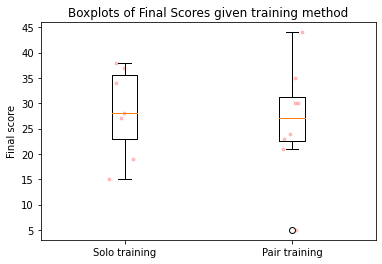

In [324]:
# Box plot results
data = [solo_results,duo_results]
plt.boxplot(data, labels=['Solo training', 'Pair training'])
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.2)
plt.ylabel('Final score')
plt.title('Boxplots of Final Scores given training method')
plt.show()


Although the mean results seem to be a bit higher for people that trained in alone, we need to check if this statistically significant. 

Here we are in the case where we want to asses if a categorical variable (the student training in pairs versus alone ) 
has an impact on a quantitative value (how well they learn). 
Thus we choose to make use of the t-test. In order to use this statistical test we have to ensure that our data follows a normal distribution and that the two samples have similiar variances.


In [34]:
print('Run Shapiro test to check for normality of our data :')

print('Shapiro test results for solo_results :\n', st.shapiro(solo_results))
print('Shapiro test results for duo_results :\n', st.shapiro(duo_results))

print('\nRun Bartlett test to check equality of variances : ')

print(st.bartlett(solo_results,duo_results))

Run Shapiro test to check for normality of our data :


NameError: name 'st' is not defined

From the Shapiro test, since for both samples the p-values is greater than 0.05, we cannot reject the null hypothesis, and thus conclude that they both follow a normal distribution. 

From the Bartlett test, we also get p-value > 0.05, thus we once again cannot reject the null hypothesis that that the variances are equal. 

We conclude that the assumptions for using t-test are met and we can run it. 


In [ ]:
print('\nRun Ttest to check for equality of means :')

print(st.ttest_ind(solo_results, duo_results))

When running our t-test, we get a p-value greater than 0.05. This means that we cannot reject the null hypothesis of the means being the same, thus we conclude that the means of our two samples are the same. 

This means that the results of our experiment are not sufficient to conclude on the difference of efficiency between training in pairs or alone.


## Link between previous knowledge and results


In [313]:
previous_to_final = []
prv_score = {}
for id_, prev_score in knowledge_ranked:
    prv_score[id_] = prev_score
for id_, final_score in total_score_ranked:
    if final_score != -1 : 
        previous_to_final.append((prv_score[id_],final_score))

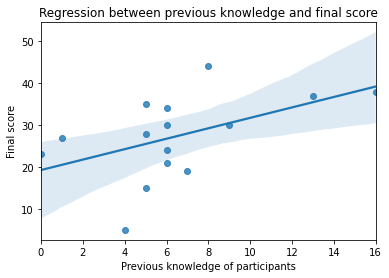

In [316]:
import seaborn as sns 
x = [s[0] for s in previous_to_final]
y = [s[1] for s in previous_to_final]
sns.regplot(x=x, y=y)
plt.xlabel("Previous knowledge of participants")
plt.ylabel("Final score")
plt.title("Regression between previous knowledge and final score")
plt.show()

We can observe a small impact of the previous knowledge on the final results but given the small size of our sample and the relatively big size of our confidence interval, we cannot really deduce much from this relationship.

## Difference between the two tricks



In [44]:
#split the two tricks
trick1_results = []
trick2_results = []

for id, score in total_score_ranked:
    if groupNumber(id) % 2 == 1: #trick1
        trick1_results.append(score)
    else:
        trick2_results.append(score)
        
trick1_results = list(filter(lambda x:x!=-1,[s for s in trick1_results]))
trick2_results = list(filter(lambda x:x!=-1,[s for s in trick2_results]))

In [47]:
trick1_results

[44, 28, 25, 24, 19]

In [48]:
trick2_results

[38, 35, 34, 30, 30, 27, 23, 21, 15, 5]

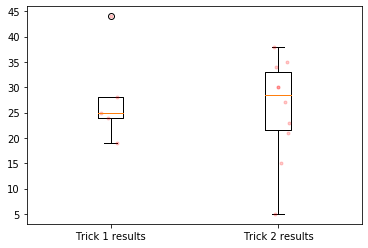

In [46]:
# Box plot results
data = [trick1_results,trick2_results]
plt.boxplot(data, labels=['Trick 1 results', 'Trick 2 results'])
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.2)
plt.show()

#print(st.describe(trick1_results))
#print(st.describe(trick2_results))

## Limitaitons :
- The size of our sample 
- The evaluation method (hard to be objective + limitations techniques) 